# Prior definition

In this notebook we demonstrate how to include prior knowledge into a parameter inference problem, in particular how to define (log-)priors for parameters. If you want to maximize your posterior distribution, you need to define

* A (negative log-)likelihood
* A (log-)prior

The posterior is then built as an `AggregatedObjective`. If you import a problem via `PEtab` and the priors are contained in the parameter table, the definition of priors is done automatically.

**CAUTION**: The user needs to specify the **negative** _log-likelihood_, while the _log-prior_ is internally mulitplied by -1.

In [1]:
# install if not done yet
# %pip install pypesto --quiet

In [2]:
import numpy as np
import scipy as sp

import pypesto

## Example: Rosenbrock Banana

We will use the Rosenbrock Banana

\begin{align}
f(x, \theta) = \sum_{i=1}^{N} \underbrace{100 \cdot(x_{i}-x_{i-1}^2)^2}_{\text{"negative log-likelihood"}} + \underbrace{(x_{i-1}-1)^2}_{\text{"Gaussian log-prior"}}
\end{align}

as an example. Here we interpret the first term as the _negative log-likelihood_ and the second term as Gaussian _log-prior_ with mean $1$ and standard deviation $1/\sqrt{2}$. 

Note that the second term is only equivalent to the negative log-distribution of a Gaussian up to a constant.

### Define the negative log-likelihood

In [3]:
n_x = 5

def rosenbrock_part_1(x):
    """
    Calculate obj. fct + gradient of the "likelihood" part.
    """
    obj = sum(100.0*(x[1:] - x[:-1]**2.0)**2.0)
    
    grad = np.zeros_like(x)
    grad[:-1] += -400 * (x[1:] - x[:-1]**2.0) * x[:-1]
    grad[1:] += 200 * (x[1:] - x[:-1]**2.0)
    
    return (obj, grad)

neg_log_likelihood = pypesto.Objective(fun=rosenbrock_part_1, grad=True)

### Define the log-prior

A prior on an individual parameter is defined in a `prior_dict`, which contains the following key-value pairs:

* `index`: Index of the parameter
* `density_fun`: (Log-)posterior. (Scalar function!)
* `density_dx`: d/dx (Log-)posterior (optional)
* `density_ddx`: d^2/dx^2 (Log-)posterior (optional)

A `prior_dict` can be either obtained by `get_parameter_prior_dict` for several common priors, or defined by the user.

In [4]:
from pypesto.objective.priors import get_parameter_prior_dict

# create a list of prior dicts...
prior_list = []
mean = 1
std_dev = 1 / np.sqrt(2)

for i in range(n_x-1):
    prior_list.append(get_parameter_prior_dict(i, 'normal', [mean, std_dev]))
    
# create the prior
neg_log_prior = pypesto.objective.NegLogParameterPriors(prior_list)

### Define the negative log-posterior and the problem

The negative log-posterior is defined as an `AggregatedObjective`. Since optimization/visualization is not the main focus of this notebook, the reader is referred to other examples for a more in-depth presentation of these.

In [5]:
neg_log_posterior = pypesto.objective.AggregatedObjective([neg_log_likelihood, neg_log_prior])

lb = -5 * np.ones((n_x, 1))
ub = 5 * np.ones((n_x, 1))

problem = pypesto.Problem(
    objective=neg_log_posterior, 
    lb=lb, 
    ub=ub,
)

### Optimize

In [6]:
import pypesto.optimize as optimize

result = optimize.minimize(problem=problem, n_starts=10, filename=None)

100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.26it/s]


### Some basic visualizations

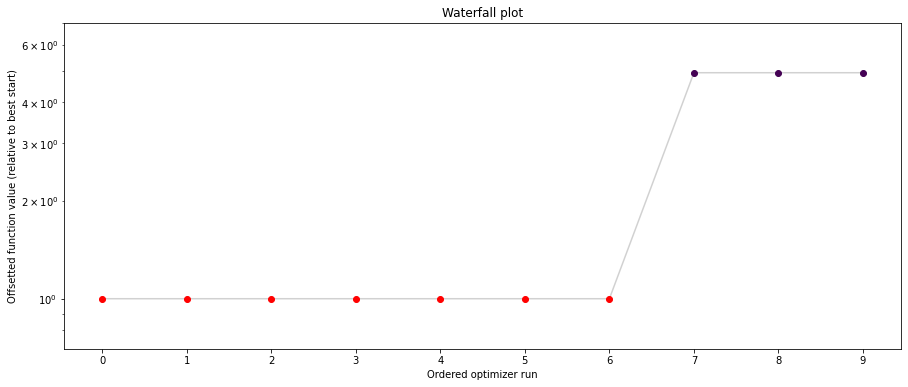

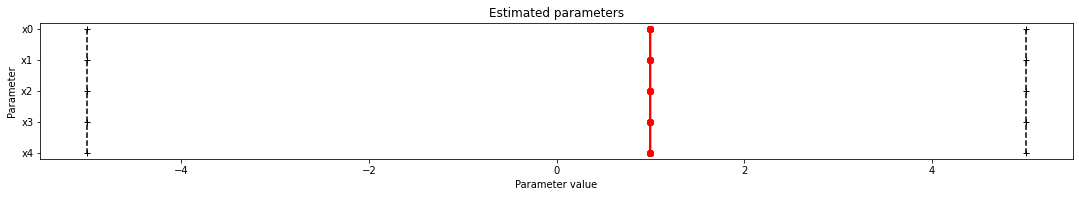

In [7]:
import pypesto.visualize as visualize

visualize.waterfall(result, size=(15, 6))

# parallel coordinates plot for best 5 fits
visualize.parameters(result, start_indices=5);